In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd
import pathlib
from pathlib import Path
import os
import seaborn as sns
import datetime
import shapely
from shapely.geometry import shape, Point, LineString, Polygon
import warnings
from google.cloud import storage

/home/delllaptop/LBNL/BEAM-Analysis/.venv/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_102277/1902307361.py:9: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you a

In [2]:
'''
Setting the current working directory. Ideally the tree should follow look the following
BEAM
- Data
- Notebooks
    - Google Cloud Scripts
    - Local Scripts
- Output
    - City Name
        - Passenger
            - simulation_name        
        - Freight
            - simulation_name
'''

# This will return the folder where the script is stored
BASE_DIR = Path.cwd()
print(BASE_DIR)

# set the project directory (two-levels up, ideally)
project_folder = BASE_DIR.parent.parent
print(project_folder)

# General Declaration
gc_url = f"https://storage.googleapis.com/beam-core-outputs/"
iteration_no = "0" #change if we refer different simulation iteration
# conversion units
meter_to_mile = 0.000621371
percent_of_samples = 0.15
mps_to_mph = 2.23694

/home/delllaptop/LBNL/BEAM-Analysis/Notebooks
/home/delllaptop/LBNL


In [3]:
def get_filenames(variable_filename):
    simulation_data = {
            f"pilates-austin-baseline-calibrated-v3/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "Baseline",
            # Transit Capacity Scenarios
            f"pilates-austin-baseline-calibrated-v3-tr-capacity-025/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Cap_25pct",
            f"pilates-austin-baseline-calibrated-v3-tr-capacity-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Cap_50pct",
            f"pilates-austin-baseline-calibrated-v3-tr-capacity-150/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Cap_150pct",
            f"pilates-austin-baseline-calibrated-v3-tr-capacity-200/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Cap_200pct",
            # # Transit Speed Scenarios
            f"pilates-austin-baseline-calibrated-v3-tr-spd-050-attmpt-4/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Spd_50pct",
            f"pilates-austin-baseline-calibrated-v3-tr-spd-066-attmpt-4/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Spd_66pct",
            f"pilates-austin-baseline-calibrated-v3-tr-spd-200/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Spd_200pct",
            f"pilates-austin-baseline-calibrated-v3-tr-spd-400/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Spd_400pct",
            # # Transit Frequency Scenarios
            f"pilates-austin-baseline-calibrated-v3-tr-freq-025/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Frq_25pct",
            f"pilates-austin-baseline-calibrated-v3-tr-freq-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Frq_50pct",
            f"pilates-austin-baseline-calibrated-v3-tr-freq-150/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Frq_150pct",
            f"pilates-austin-baseline-calibrated-v3-tr-freq-200/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Frq_200pct",
            # # Transit Fare Reduction Scenarios
            f"pilates-austin-baseline-calibrated-v3-tr-incentive-0c/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Inc_0c",
            f"pilates-austin-baseline-calibrated-v3-tr-incentive-25c/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Inc_25c",
            f"pilates-austin-baseline-calibrated-v3-tr-incentive-50c/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Inc_50c",
            f"pilates-austin-baseline-calibrated-v3-tr-incentive-75c/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "TR_Inc_75c",
            # # Ridehail price Scenarios
            f"pilates-austin-baseline-calibrated-v3-rh-price-0125/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_price_12.5pct",
            f"pilates-austin-baseline-calibrated-v3-rh-price-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_price_50pct",
            f"pilates-austin-baseline-calibrated-v3-rh-price-200/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_price_200pct",
            f"pilates-austin-baseline-calibrated-v3-rh-price-500/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_price_500pct",
            # # # Ridehail fleet size
            f"pilates-austin-baseline-calibrated-v3-rh-fleetsize-0125/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_fleetsize_12.5pct",
            f"pilates-austin-baseline-calibrated-v3-rh-fleetsize-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_fleetsize_50pct",
            f"pilates-austin-baseline-calibrated-v3-rh-fleetsize-300-attmpt-2/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_fleetsize_300pct",
            f"pilates-austin-baseline-calibrated-v3-rh-fleetsize-1000/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_fleetsize_1000pct",
            # # # Ridehail fleet reposition
            f"pilates-austin-baseline-calibrated-v3-rh-reposition-0125/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_reposition_12.5pct",
            f"pilates-austin-baseline-calibrated-v3-rh-reposition-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_reposition_50pct",
            f"pilates-austin-baseline-calibrated-v3-rh-reposition-300/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_reposition_300pct",
            f"pilates-austin-baseline-calibrated-v3-rh-reposition-1000/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_reposition_1000pct",
            # # # Ridehail fleet detour
            f"pilates-austin-baseline-calibrated-v3-rh-detour-0125/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_detour_12.5pct",
            f"pilates-austin-baseline-calibrated-v3-rh-detour-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_detour_50pct",
            f"pilates-austin-baseline-calibrated-v3-rh-detour-300/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_detour_300pct",
            f"pilates-austin-baseline-calibrated-v3-rh-detour-1000/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "RH_detour_1000pct",
            # # # NMT Incentives
            f"pilates-austin-baseline-calibrated-v3-nmt-incentive-025/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "NMT_Inc_25c",
            f"pilates-austin-baseline-calibrated-v3-nmt-incentive-050/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "NMT_Inc_50c",
            f"pilates-austin-baseline-calibrated-v3-nmt-incentive-100/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "NMT_Inc_100c",
            f"pilates-austin-baseline-calibrated-v3-nmt-incentive-200/beam/year-2020-iteration-4/ITERS/it.{iteration_no}/{iteration_no}.{variable_filename}": "NMT_Inc_200c",
        }
    return simulation_data
    

In [4]:
def linkstats_to_df(_filepath):
    df = pd.read_csv(_filepath, compression="gzip", low_memory=False)
    df["volume"] = df["volume"].fillna(0)
    df["length"] = df["length"].fillna(0)
    df["vmt"] = df["length"]*0.00062137*df["volume"]*(1/percent_of_samples)
    _VMT_sum = df["vmt"].sum()
    
    # add congested speed (mph)
    df["congested_speed_mph"] = (df["length"]/df["traveltime"])*2.23694
    # add free-flow speed (mph)
    df["freeflow_speed_mph"] = df["freespeed"]*2.23694
    # add vehicle hours of delay (free flow speed - congested speed)* volume
    df["VHD"] = ((df["freeflow_speed_mph"]-df["congested_speed_mph"])*(df["volume"])*(1/percent_of_samples))/(60*60)
    VHD_sum = df["VHD"].sum()
    # calculate VHT
    df["VHT"] = df["volume"]*(df["traveltime"]/(60*60))*(1/percent_of_samples)
    
    _VHT_sum = df["VHT"].sum()
    # calculate VMT VHT Ratio
    # _VMT_VHT_ratio = np.divide(_VMT_sum, _VHT_sum)
    
    return _VMT_sum, _VHT_sum

linkstats_filename = "linkstats.csv.gz"
variable_filename = linkstats_filename
simulation_data = get_filenames(variable_filename)
data_names = simulation_data.keys()

sensitivity_name = list()
VMT_list = list()
VHT_list = list()
VMT_VHT_ratio_list = list()

data_names = simulation_data.keys()
for data_name in data_names:
    VMT_sum, VHT_sum = linkstats_to_df(f"{gc_url}{data_name}")
    # print("LinkStatistics")
    # print(f"Simulation {simulation_data[data_name]} - VMT: {dfAustinAreaBeam.VMT_sum}, VHT: {dfAustinAreaBeam.VHT_sum}, ratio:{dfAustinAreaBeam.VMT_VHT_ratio}")
    sensitivity_name.append(simulation_data[data_name])
    VMT_list.append(VMT_sum)
    VHT_list.append(VHT_sum)
    VMT_VHT_ratio_list.append(np.divide(VMT_sum, VHT_sum))

In [ ]:
def getBoardingsDetails(_filepath):
    df = pd.read_csv(_filepath, compression="gzip", low_memory=True)
    df["Travel_Time"] = df["arrivalTime"] - df["departureTime"]
    
    # get total agents count
    total_agents_counts  = df.loc[(~df["person"].str.startswith("rideHailAgent",na=False)) & (~df["person"].str.startswith("TransitDriverAgent",na=False)),"person"].nunique()
    rhagents_counts = df.loc[df["person"].str.startswith("rideHailAgent", na=False),"person"].nunique()
    
    
    PersonEnterVehicles = df.loc[(df["type"]=="PersonEntersVehicle") & 
                                 (~df["vehicle"].str.contains("rideHailVehicle",na=False)) & 
                                 (~df["person"].str.contains("TransitDriverAgent",na=False))].copy()
    
    # create dictionary: vehicle:mode
    veh_mode_df = df.loc[(df["type"]=="PathTraversal") & (df["vehicle"].str.contains("capmetro", na=False))]
    veh_mode = dict(zip(veh_mode_df.vehicle, veh_mode_df["mode"]))
    # map them to get number of boardings by PT mode
    PersonEnterVehicles["mode_veh"] = PersonEnterVehicles["vehicle"].map(veh_mode,na_action='ignore')
    # get counts
    veh_counts = PersonEnterVehicles[~PersonEnterVehicles["mode_veh"].isna()].mode_veh.value_counts()
    bus_boarding = veh_counts.bus*(1/percent_of_samples)
    tram_boarding = veh_counts.tram*(1/percent_of_samples)
        
    return total_agents_counts, rhagents_counts, bus_boarding, tram_boarding
    
events_filename = "events.csv.gz"
variable_filename = events_filename
simulation_data = get_filenames(variable_filename)
data_names = simulation_data.keys()
no_of_agents_list = list()
busboardings_list = list()
tramboardings_list = list()

for data_name in data_names:
    # print(f"{gc_url}{data_name}")
    total_agents_counts, rhagents_counts, bus_boardings, tram_boardings = getBoardingsDetails(f"{gc_url}{data_name}")
    no_of_agents_list.append(total_agents_counts)
    busboardings_list.append(bus_boardings)
    tramboardings_list.append(tram_boardings)

In [ ]:
scenario_explanation = [
"Baseline", "Transit Capacity equals to 25pct of baseline", "Transit Capacity equals to 50pct of baseline", 
"Transit Capacity equals to 150pct of baseline", "Transit Capacity equals to 200pct of baseline",
"Transit Speed equals 50pct of baseline", "Transit Speed equals 66pct of baseline",
"Transit Speed equals 200pct of baseline", "Transit Speed equals 400pct of baseline", 
"Transit frequency equals 25pct of baseline", "Transit frequency equals 50pct of baseline",
"Transit frequency equals 150pct of baseline", "Transit frequency equals 200pct of baseline",
"Transit incentive where fare equals to 0 compared to baseline", "Transit incentive where fare is reduced by 25cents compared to baseline",
"Transit incentive where fare is reduced by 50cents compared to baseline", "Transit incentive where fare is reduced by 75cents compared to baseline",
"Ridehail price is 12.5pct of baseline", "Ridehail price is 50pct of baseline", 
"Ridehail price is 200pct of baseline", "Ridehail price is 500pct of baseline", 
"Ridehail fleetsize is 12.5pct of baseline", 'Ridehail fleetsize is 50pct of baseline',
"Ridehail fleetsize is 300pct of baseline","Ridehail fleetsize is 1000pct of baseline",
"Ridehail reposition is done for 12.5pct of fleets compared to baseline","Ridehail reposition is done for 50pct of fleets compared to baseline",
"Ridehail reposition is done for 300 pct of fleets compared to baseline","Ridehail reposition is done for 1000pct of fleets compared to baseline",
"Ridehail detour is done for 12.5pct of fleets compared to baseline","Ridehail detour is done for 50pct of fleets compared to baseline",
"Ridehail detour is done for 300 pct of fleets compared to baseline","Ridehail detour is done for 1000pct of fleets compared to baseline",
"Nonmotorized modes given incentives 25c more than baseline","Nonmotorized modes given incentives 50c more than baseline",
"Nonmotorized modes given incentives 100c more than baseline","Nonmotorized modes given incentives 200c more than baseline",
]

PyperclipException: 
    Pyperclip could not find a copy/paste mechanism for your system.
    For more information, please visit
    https://pyperclip.readthedocs.io/en/latest/#not-implemented-error
    

In [ ]:
dictComparisionTable = {
                        "simulation_name":sensitivity_name,
                        
                        "VMT": VMT_list,
                        "VHT": VHT_list,
                        "ratio": VMT_VHT_ratio_list,
                        "noofagents" : no_of_agents_list,
                        "BusBoardings" : busboardings_list,
                        "tramboardings": tram_boardings
                        }

dfComparisionTable = pd.DataFrame.from_dict(dictComparisionTable)
# Convert VMTs in VMTs in millions
dfComparisionTable["VMT_millions"] = np.divide(dfComparisionTable["VMT"],1000000)
baseline_vmt = dfComparisionTable.loc[0,"VMT_millions"]
dfComparisionTable["Baseline_VMT"] = baseline_vmt

# Convert VHT in VHTs in thousand_hours
dfComparisionTable["VHT_thousands"] = np.divide(dfComparisionTable["VHT"],1000)
baseline_vht = dfComparisionTable.loc[0,"VHT_thousands"]
dfComparisionTable["Baseline_VHT"] = baseline_vht

# Baseline BusBoardings
baseline_BusBoardings = dfComparisionTable.loc[0,"BusBoardings"]
dfComparisionTable["Baseline_BusBoardings"] = baseline_BusBoardings

# calculate perecentage change in VMT
dfComparisionTable["pct_change_VMT_wrt_Baseline"] = ((dfComparisionTable["VMT_millions"] - dfComparisionTable["Baseline_VMT"])*100/dfComparisionTable["Baseline_VMT"])

# calculate perecentage change in VHT
dfComparisionTable["pct_change_VHT_wrt_Baseline"] = ((dfComparisionTable["VHT_thousands"] - dfComparisionTable["Baseline_VHT"])*100/dfComparisionTable["Baseline_VHT"])

# calculate perecentage change in bus ridership
dfComparisionTable["pct_change_busridership_wrt_Baseline"] = ((dfComparisionTable["BusBoardings"] - dfComparisionTable["Baseline_BusBoardings"])*100/dfComparisionTable["Baseline_BusBoardings"])


# save
dfComparisionTable.to_csv(project_folder.joinpath("BEAM-Analysis", "Output", "austin", "Passenger", "Austin_SummaryTables", "VMT_VHT_Transit.csv"))


In [ ]:
dfComparisionTable = pd.read_csv(project_folder.joinpath("BEAM-Analysis", "Output", "austin", "Passenger", "Austin_SummaryTables", "VMT_VHT_Transit.csv"))
# calculate perecentage change in vHT
dfComparisionTable["pct_change_busridership_wrt_Baseline"] = ((dfComparisionTable["BusBoardings"] - dfComparisionTable["Baseline_BusBoardings"])*100/dfComparisionTable["Baseline_BusBoardings"])

In [ ]:
# from bokeh.plotting import figure, show
# p = figure(x_range=dfComparisionTable["simulation_name"], height=550, title="% Change in VMT wrt Baseline", toolbar_location=None, tools="")
# p.vbar(x=dfComparisionTable["simulation_name"], top=dfComparisionTable["pct_change_VHT_wrt_Baseline"], width=0.9)

# p.xgrid.grid_line_color = None
# p.y_range.start = 0

# show(p)

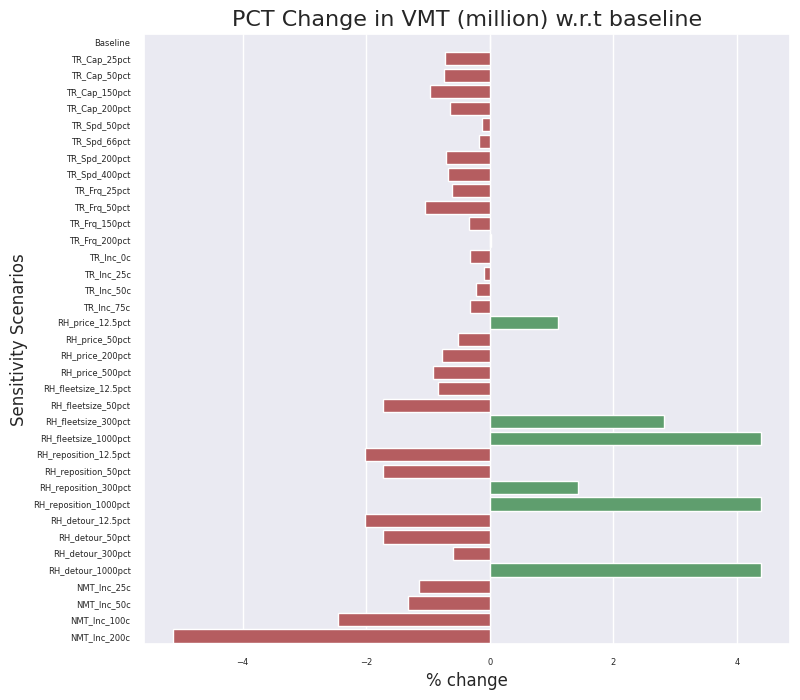

In [ ]:
# plot figure size (Width x Height (in inches))
plt.figure(figsize=(8,7)) # default plotsize = width of 6.4 inches and a height of 4.8 inches

# mark color red, if drop in % wrt Baseline other green
colormat=np.where(dfComparisionTable["pct_change_VMT_wrt_Baseline"]>0, 'g','r')

# Horizontal barplot for VMT
sns.barplot(y = dfComparisionTable["simulation_name"], x = dfComparisionTable["pct_change_VMT_wrt_Baseline"], palette=colormat)
# change specifically label font sizes using plt.xlabel()
sns.set(font_scale=0.55)

#add plot title
plt.title('PCT Change in VMT (million) w.r.t baseline', fontsize=16)

#add axis labels
plt.xlabel('% change', fontsize=12)
plt.ylabel('Sensitivity Scenarios', fontsize=12)


plt.tight_layout()

# save the plot as JPG file
plt.savefig("Change_in_VMT.jpg", dpi=600)


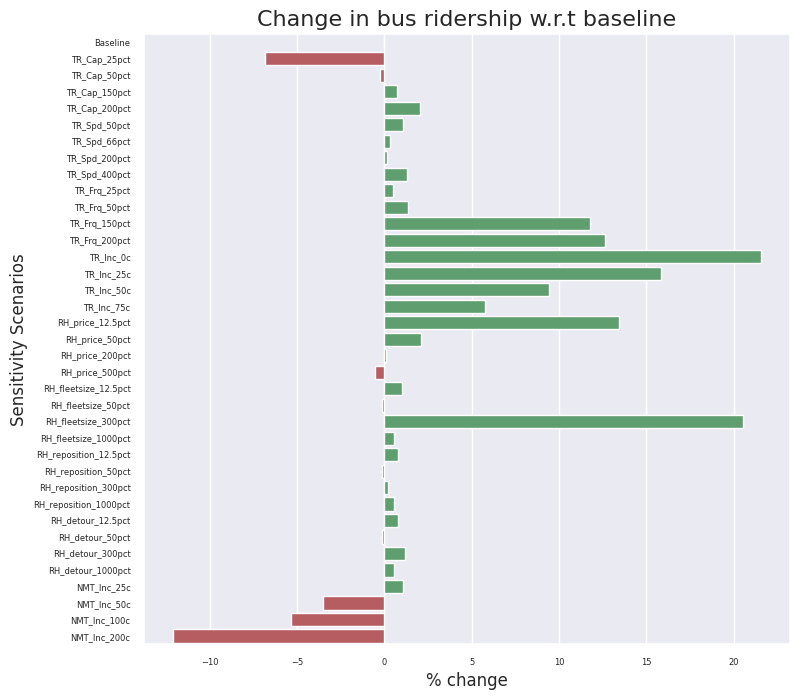

In [ ]:
# plot figure size (Width x Height (in inches))
plt.figure(figsize=(8,7)) # default plotsize = width of 6.4 inches and a height of 4.8 inches

# mark color red, if drop in % wrt Baseline other green
colormat=np.where(dfComparisionTable["pct_change_busridership_wrt_Baseline"]>0, 'g','r')

# Horizontal barplot for VMT
sns.barplot(y = dfComparisionTable["simulation_name"], x = dfComparisionTable["pct_change_busridership_wrt_Baseline"], palette=colormat)
# change specifically label font sizes using plt.xlabel()
sns.set(font_scale=0.55)

#add plot title
plt.title('Change in bus ridership w.r.t baseline', fontsize=16)

#add axis labels
plt.xlabel('% change', fontsize=12)
plt.ylabel('Sensitivity Scenarios', fontsize=12)

plt.tight_layout()

# save the plot as JPG file
plt.savefig("Change_in_bus_ridership.jpg", dpi=600)
